In [2]:
# fit binodal curve based on Flory-Huggins Theory
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Tstar_scale = 0.009935
density_scale = 1000 / (50*110) # mg/mL -> mM

def critical(n=1):
    """
    Calculates the critical point for a given polymer length.

    Equation (3) in the paper.

    I don't understand why this works or where these functional
    forms come from?

    Parameters
    -----------------
    n : int
        Polymer length.


    Returns
    ---------------
    np.array of l=2
        Returns an numpy array with 2 elements
        [0] - volume fraction at critical point
        [1] - chi at critical point

    """

    x_c = 0.5 * np.power(1. + 1. / np.sqrt(n), 2)
    phi_c = 1. / (1. + np.sqrt(n))
    return np.array([phi_c, x_c])

def GL_binodal(x, n=1):
    """
    GL = Ginzerberg-Landau

    """

    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]

    if not np.array(x).shape:
        if x > x_c:
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])
        else:
            raise ValueError('interaction strength too small - no LLPS!')
    else:
        if max(x) < x_c:
            raise ValueError('interaction strength too small - no LLPS!')
        else:
            x = np.array(x)
            x = x[x >= x_c]
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])

def binodal(x, n=1, iteration=5, UseImprovedMap=True):

    assert iteration >= 0
    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]
    gamma = 1. - 1. / n

    if n == 1:

        guess = GL_binodal(x)

        pp = guess[0]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = (2. * xx * pp * ee - 1. - ee) / (2. * xx * ee - (1. + ee)**2)

        else:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = 1 / (1 + ee)

        return np.array([pp, 1 - pp, xx])

    if n > 1:

        guess = GL_binodal(x, n=n)

        p1 = guess[0]
        p2 = guess[1]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                d1lna = - 2. * xx
                d1lnb = - gamma - xx * 2. * p1
                d2lna = 2. * xx
                d2lnb = gamma + xx * 2. * p2

                j11 = g1**2 * (- d1lnb * b * (1 - c) / (1 - b)**2 + n * (d1lna - d1lnb) * c * b / (1 - b)) - 1
                j21 = g1**2 * (- d2lnb * b * (1 - c) / (1 - b)**2 + n * (d2lna - d2lnb) * c * b / (1 - b))
                j12 = (j11 + 1) * c + g1 * n * c * (d1lna - d1lnb)
                j22 = j21 * c + g1 * n * c * (d2lna - d2lnb) - 1

                detj = j11 * j22 - j12 * j21

                p1_new = np.copy(p1 + (- (g1 - p1) * j22 + (g2 - p2) * j21) / detj)
                p2_new = np.copy(p2 + (- (g2 - p2) * j11 + (g1 - p1) * j12) / detj)

                p1 = p1_new
                p2 = p2_new

        else:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                p1_new = np.copy((1. - b) / (1. - np.power(a / b, n) * b))
                p2_new = np.copy((1. - b) / (np.power(b / a, n) - b))

                p1 = p1_new
                p2 = p2_new

        return np.array([p1, p2, xx])

def theoretical_binodal(T, Tc, delta_eps=500, rho_scale=1000.0, chi0=0):
    chic = delta_eps / Tc + chi0
    n = ((2*chic)**0.5-1)**(-2)
    chis = delta_eps / T + chi0

    rho_dense, rho_dilute = [], []
    for chi in chis:
        try:
            x = binodal(chi, n=n)
            phi_dense, phi_dilute = x[0], x[1]
            rho_dense.append(phi_dense * rho_scale)
            rho_dilute.append(phi_dilute * rho_scale)
        except ValueError:
            rho_dense.append(np.nan)
            rho_dilute.append(np.nan)
    return np.array(rho_dense), np.array(rho_dilute)

def loss(params, T_sim, rho_dense_exp, rho_dilute_exp, Tc, fit_chi0=True):
    if fit_chi0:
        delta_eps, rho_scale, chi0 = params
    else:
        delta_eps, rho_scale = params
        chi0 = 0.0
    if rho_scale <= 0:
        return np.inf
    rho_dense_th, rho_dilute_th = theoretical_binodal(T_sim, Tc, delta_eps, rho_scale, chi0)
    mask = ~np.isnan(rho_dense_th)
    if not np.any(mask):
        return np.inf
    mse = np.mean((rho_dense_th[mask] - rho_dense_exp[mask])**2 +
                  (rho_dilute_th[mask] - rho_dilute_exp[mask])**2)
    return mse

def fit_FH_binodal(T_sim, rho_dense, rho_dilute, Tc, fit_chi0=False):
    T_sim = np.array(T_sim)
    rho_dense = np.array(rho_dense)
    rho_dilute = np.array(rho_dilute)

    if fit_chi0:
        x0 = [300, 1200.0, 0.0]
    else:
        x0 = [200, 1200.0]
    
    res = minimize(loss, x0, args=(T_sim, rho_dense, rho_dilute, Tc, fit_chi0),
                   method='Nelder-Mead', options={'maxiter': 2000})
    if fit_chi0:
        delta_eps_fit, rho_scale_fit, chi0_fit = res.x
    else:
        delta_eps_fit, rho_scale_fit = res.x
        chi0_fit = 0.0
    T_range = np.linspace(min(T_sim)-100, Tc+1, 1000)
    rho_dense_fit, rho_dilute_fit = theoretical_binodal(T_range, Tc, delta_eps_fit, rho_scale_fit, chi0_fit)
    rho_fit = np.column_stack([rho_dilute_fit, rho_dense_fit[::-1]])
    T_fit = np.column_stack([T_range, T_range[::-1]])
    rhoc = (np.nanmax(rho_dilute_fit) + np.nanmin(rho_dense_fit)) / 2

    return rho_fit, T_fit, rhoc

/home/swalker/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/tmp/ipykernel_1719032/437478642.py:97: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


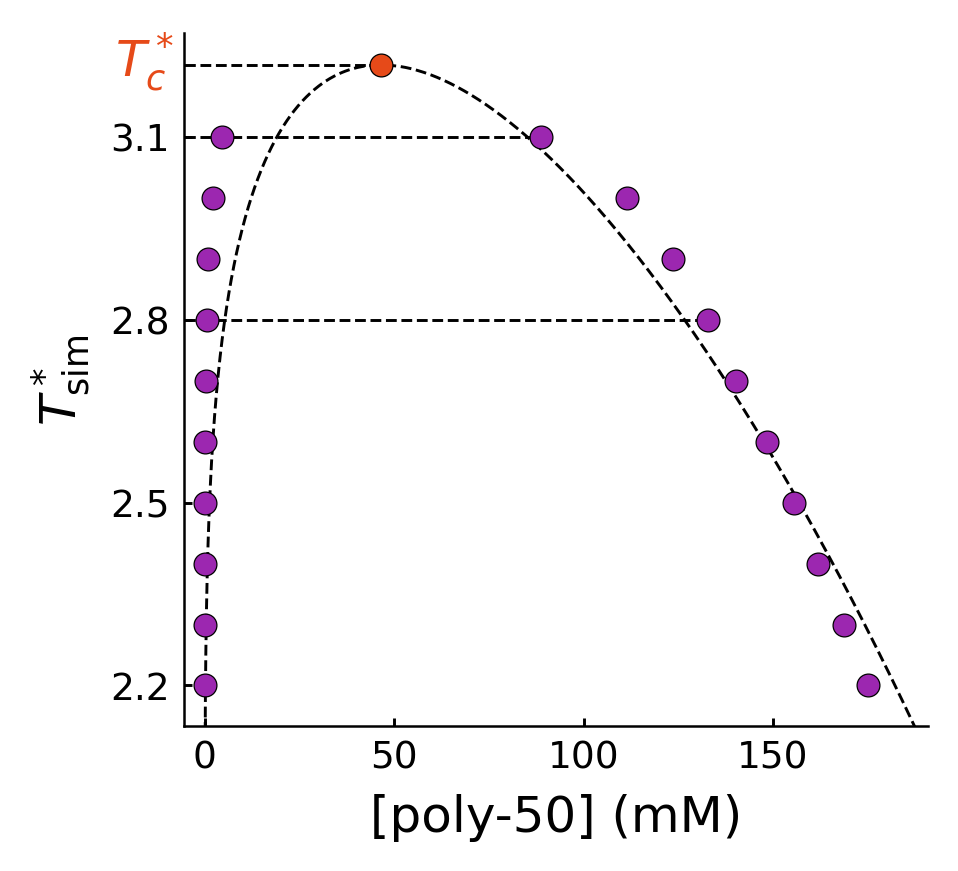

In [2]:
# Fig.A
import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import leastsq

protein = 'poly50'
fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)

## Plot density profile
data_folder = f'data/{protein}/hps'
RHO_H, RHO_L, T = [], [], []
for temp in range(220, 360, 10):
    traj_dir = f'traj/{protein}/hps/{temp}/{temp}'
    if not os.path.exists(f'traj/{protein}/hps/{temp}'):
        continue
    u = mda.Universe(f'{traj_dir}.gsd', f'{traj_dir}.dcd')
    nlen = len(u.trajectory)
    natoms = u.atoms.n_atoms
    mass = u.atoms.masses
    name = u.atoms.names
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nbins = 500
    nres = 168
    dz = lenz / nbins
    axisz = np.linspace(zmin, zmax, nbins)

    if os.path.exists(f'{data_folder}/{temp}_dp.npy'):
        rhoave = np.load(f'{data_folder}/{temp}_dp.npy')
    else:
        count = 0
        rhosum = np.zeros(nbins)
        for frame in np.arange(300, nlen, 2):
            if frame % 100 == 0:
                print(frame)
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for i in range(natoms):
                nposz = ts.positions[i][2] - cmassz
                nmass = mass[i]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            rhosum += rhoz
            count += 1
        rhoave = rhosum / count
        rhoidx = np.where(rhoave > max(rhoave) * 0.2)
        mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
        if mc_idx > 0:
            tmp = rhoave[:mc_idx].copy()
            rhoave[:-mc_idx] = rhoave[mc_idx:]
            rhoave[-mc_idx:] = tmp
        if mc_idx < 0:
            tmp = rhoave[mc_idx:].copy()
            rhoave[-mc_idx:] = rhoave[:mc_idx]
            rhoave[:-mc_idx] = tmp
        
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        np.save(f'{data_folder}/{temp}_dp.npy', rhoave)
    
    rho_max = max(rhoave)
    rho_min = min(rhoave)
    rho_hd, rho_ld = 0, 0
    count_hd, count_ld = 0, 0
    for rho in rhoave:
        if rho >= rho_max * 0.95:
            rho_hd += rho
            count_hd += 1
        if rho <= rho_min + 50:
            rho_ld += rho
            count_ld += 1
    rho_hd /= count_hd
    rho_ld /= count_ld

    rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
    rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

    if abs(rho_hd - rho_ld) <= 50:
        continue

    T.append(temp)
    RHO_H.append(rho_hd)
    RHO_L.append(rho_ld)

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

RHO_H = np.array(RHO_H)
RHO_L = np.array(RHO_L)
T = np.array(T)

delta_rho = RHO_H - RHO_L
rho_ave = (RHO_H + RHO_L) / 2
T_prods = T
param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
A, T_c = param[0]
param = leastsq(err_rhoc, [0, 0], args=(T_prods, rho_ave))
B, C = param[0]
rho_c = B + C * T_c

## Plot original T
rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
plt.scatter(RHO_H*density_scale, T*Tstar_scale, s=30, c='#9C27B0', edgecolors='k', linewidths=0.3, zorder=10)
plt.scatter(RHO_L*density_scale, T*Tstar_scale, s=30, c='#9C27B0', edgecolors='k', linewidths=0.3, zorder=10)
plt.scatter(rhoc*density_scale, T_c*Tstar_scale, s=30, c='#E64A19', edgecolors='k', linewidths=0.3, zorder=10)
plt.plot(rho_fit*density_scale, T_fit*Tstar_scale, c='k', ls='--', lw=0.7)

plt.plot([-100, 730*density_scale], [280*Tstar_scale, 280*Tstar_scale], '--k', linewidth=0.7)
plt.plot([-100, 490*density_scale], [310*Tstar_scale, 310*Tstar_scale], '--k', linewidth=0.7)
plt.plot([-100, rhoc*density_scale], [T_c*Tstar_scale, T_c*Tstar_scale], '--k', linewidth=0.7)

plt.xlim(-30*density_scale, 1050*density_scale)
plt.ylim(2.12, 3.25)
plt.xlabel('[poly-50] (mM)', fontsize=12)
plt.ylabel(r'$T_\mathregular{sim}^*$', fontsize=12)
# plt.legend(fontsize=8, frameon=False)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
plt.yticks([220*Tstar_scale, 250*Tstar_scale, 280*Tstar_scale, 310*Tstar_scale])
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.text(-130*density_scale, 320*Tstar_scale, r'$T_c^*$', fontsize=12, color='#E64A19')
for spine in ax.spines.values():
    spine.set_linewidth(0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f"../../figures/phase-diagram/new_plot/density-profile.svg", format="svg", bbox_inches='tight')
plt.show()

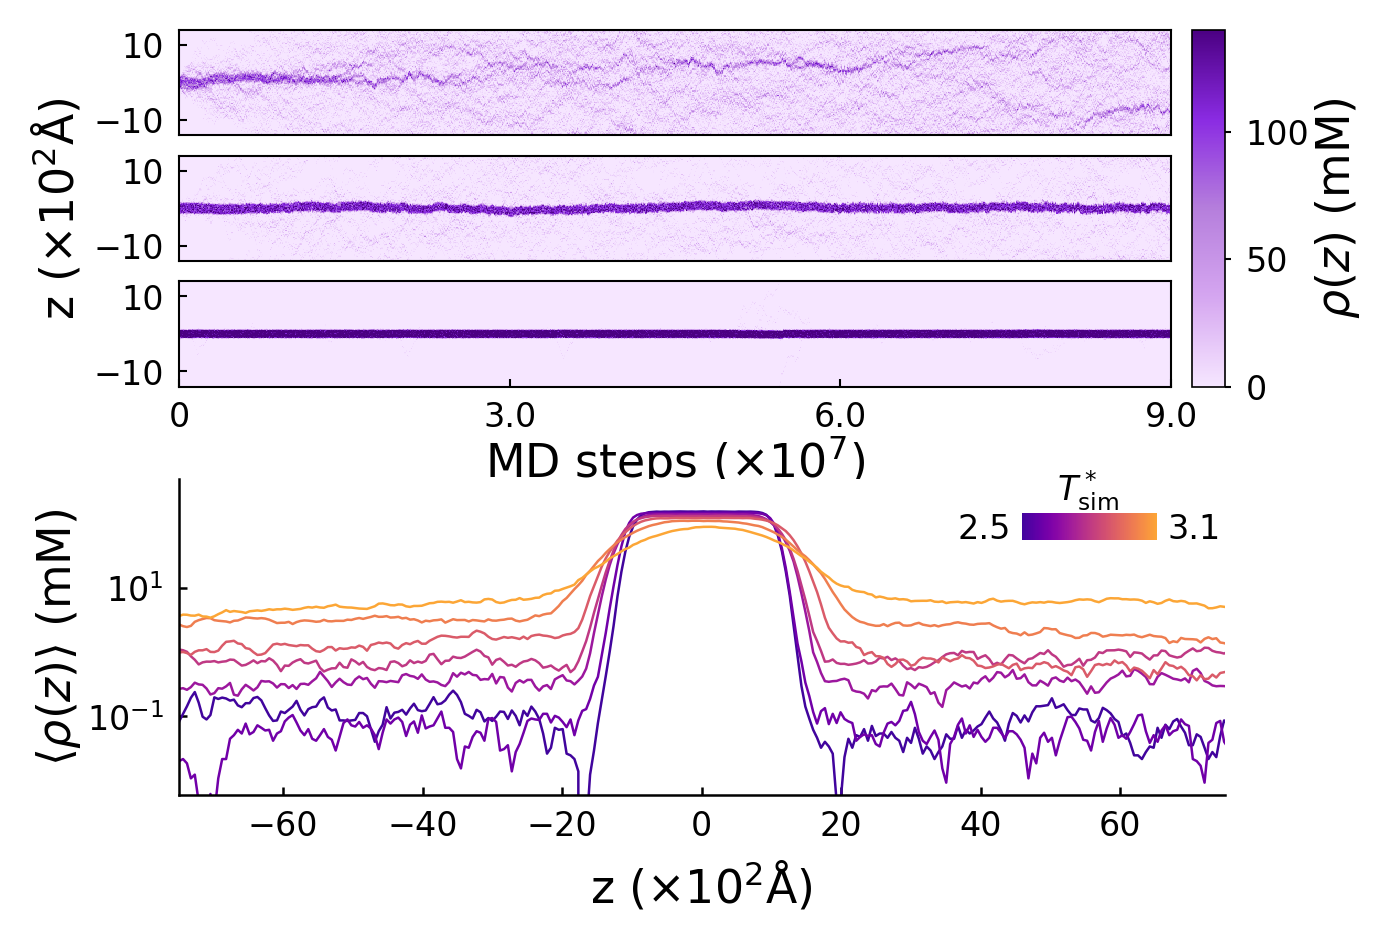

In [3]:
# Fig.C
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib import colors, ticker
from matplotlib.colors import Normalize

bright_purple = mpl.colors.LinearSegmentedColormap.from_list(
    "bright_purple", 
    [
        (0.0, "#F6E6FF"),  # very light lavender
        (0.25, "#D5A6F0"), # light purple
        (0.5, "#B57EDC"),  # amethyst
        (0.75, "#8A2BE2"), # bright violet
        (1.0, "#4B0082"),  # indigo
    ]
)

def plot_density_to_time(ax, t_sim):
    data_folder = f'data/{protein}/{folder}'
    if os.path.exists(f'{data_folder}/{t_sim}_dm.npy'):
        density_map = np.load(f'{data_folder}/{t_sim}_dm.npy')
    else:
        traj_folder = f'traj/{protein}/{folder}/{t_sim}'
        u = mda.Universe(f'{traj_folder}/{t_sim}.gsd', f'{traj_folder}/{t_sim}.dcd')
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        mass = u.atoms.masses
        name = u.atoms.names
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        dz = lenz / nbins
        axisz = np.linspace(zmin, zmax, nbins)
        density_map = np.zeros((nbins, 900))
        for frame in np.arange(0, 900):
            if frame % 100 == 0:
                print(frame)
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for j in range(natoms):
                nposz = ts.positions[j][2] - cmassz
                nmass = mass[j]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            density_map[:, frame] = rhoz
        
        np.save(f'{data_folder}/{t_sim}_dm.npy', density_map)
    
    density_map = density_map * density_scale
    norm = colors.Normalize(vmin=0, vmax=140)
    t_axis = np.arange(0, 900, 1)
    z_axis = np.linspace(-14, 14, 500)
    tt, zz = np.meshgrid(t_axis, z_axis)
    im = ax.pcolormesh(tt, zz, density_map, norm=norm, cmap=bright_purple)
    ax.set_xticks([])
    ax.set_yticks([-10, 10])
    ax.tick_params(labelsize=8, direction='in', width=0.5, length=2)
    # ax.text(705, 6.5, r'$T^*$= %.2f'%(t_sim*Tstar_scale), fontsize=10)

    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)

    return im

protein = 'poly50'
folder = 'hps'
temp = [320, 300, 260]

fig = plt.figure(figsize=[4.5, 3], facecolor='w', dpi=300)
gs = gridspec.GridSpec(4, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1, 3], wspace=0.04, hspace=0.13, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
cax = fig.add_subplot(gs[0:3, 1])
ax4 = fig.add_subplot(gs[3, 0:2])

im1 = plot_density_to_time(ax1, temp[0])
im2 = plot_density_to_time(ax2, temp[1])
im3 = plot_density_to_time(ax3, temp[2])
im1.set_rasterized(True)
im2.set_rasterized(True)
im3.set_rasterized(True)
ax3.set_xticks([0, 300, 600, 900])
ax3.set_xticklabels(['0', '3.0', '6.0', '9.0'])
ax3.set_xlabel(r"MD steps ($\times 10^7$)", labelpad=0, fontsize=11)

pos1 = ax1.get_position()
pos2 = ax3.get_position()
y_center = (pos1.y0 + pos2.y1) / 2
fig.text(0.015, y_center, r'z ($\times 10^2 \mathregular{\AA})$', va='center', rotation='vertical', fontsize=11)

cbar = fig.colorbar(im1, cax=cax)
cbar.set_label(r"$\rho(z)$ (mM)", fontsize=11, labelpad=1)
cbar.ax.tick_params(labelsize=8, length=1.5, width=0.5)
cbar.set_ticks([0, 50, 100])

for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.4)

pos4 = ax4.get_position()
ax4.set_position([pos4.x0, pos4.y0 - 0.08, pos4.width, pos4.height])

# plot ax4
tlist = np.arange(250, 320, 10)
data_folder = f'data/{protein}/{folder}'
cmap = cm.plasma
clist = cmap(np.linspace(0.1, 0.8, len(tlist)))
for index, temp in enumerate(tlist):
    traj_folder = f'traj/{protein}/{folder}/{temp}'
    if not os.path.exists(traj_folder):
        continue
    u = mda.Universe(f'{traj_folder}/{temp}.gsd', f'{traj_folder}/{temp}.dcd', pbc=True)
    at = u.select_atoms('all')
    nlen = len(u.trajectory)
    natoms = u.atoms.n_atoms
    mass = u.atoms.masses
    name = u.atoms.names
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nbins = 500
    nres = 168
    dz = lenz / nbins
    axisz = np.linspace(zmin, zmax, nbins)

    if os.path.exists(f'{data_folder}/{temp}_dp1.npy'):
        rhoave = np.load(f'{data_folder}/{temp}_dp1.npy')
    else:
        count = 0
        rhosum = np.zeros(nbins)
        for frame in np.arange(300, nlen, 1):
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for i in range(natoms):
                nposz = ts.positions[i][2] - cmassz
                nmass = mass[i]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            rhosum += rhoz
            count += 1
        rhoave = rhosum / count
        rhoidx = np.where(rhoave > max(rhoave) * 0.2)
        mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
        if mc_idx > 0:
            tmp = rhoave[:mc_idx].copy()
            rhoave[:-mc_idx] = rhoave[mc_idx:]
            rhoave[-mc_idx:] = tmp
        if mc_idx < 0:
            tmp = rhoave[mc_idx:].copy()
            rhoave[-mc_idx:] = rhoave[:mc_idx]
            rhoave[:-mc_idx] = tmp
        
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        np.save(f'{data_folder}/{temp}_dp1.npy', rhoave)
    
    rhoave = rhoave*density_scale
    ax4.plot(axisz, rhoave, lw=0.6, color=clist[index])

cbar_ax4 = fig.add_axes([0.75, 0.313, 0.1, 0.03])
cmap_partial = mpl.colors.ListedColormap(cmap(np.linspace(0.1, 0.8, 256)))
norm = Normalize(vmin=-1, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax4, orientation='horizontal')
cbar.outline.set_linewidth(0.)
cbar.set_ticks([])

ax4.text(0.84, 0.93, r'$T^*_\mathregular{sim}$', fontsize=8, transform=ax4.transAxes)
ax4.text(0.745, 0.81, '{:.1f}'.format(min(tlist)*Tstar_scale), fontsize=8, transform=ax4.transAxes)
ax4.text(0.945, 0.81, '{:.1f}'.format(max(tlist)*Tstar_scale), fontsize=8, transform=ax4.transAxes)

ax4.set_xlim(-75, 75)
ax4.set_ylim(0.006, 500)
ax4.set_xlabel(r'z ($\times 10^2 \mathregular{\AA})$', fontsize=11)
ax4.set_ylabel(r'$\langle\rho(z)\rangle$ (mM)', fontsize=11, labelpad=1)
ax4.set_yscale('log')
ax4.tick_params(labelsize=8, direction='in', length=2, width=0.6)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_linewidth(0.6)
ax4.spines['bottom'].set_linewidth(0.6)
plt.savefig(f"../../figures/phase-diagram/new_plot/density2time.svg", format="svg", bbox_inches='tight')
plt.show()

/tmp/ipykernel_1723015/3396172969.py:15: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho
/tmp/ipykernel_1723015/2566504744.py:110: RuntimeWarning: overflow encountered in power
  g2 = (1. - b) / (np.power(b / a, n) - b)


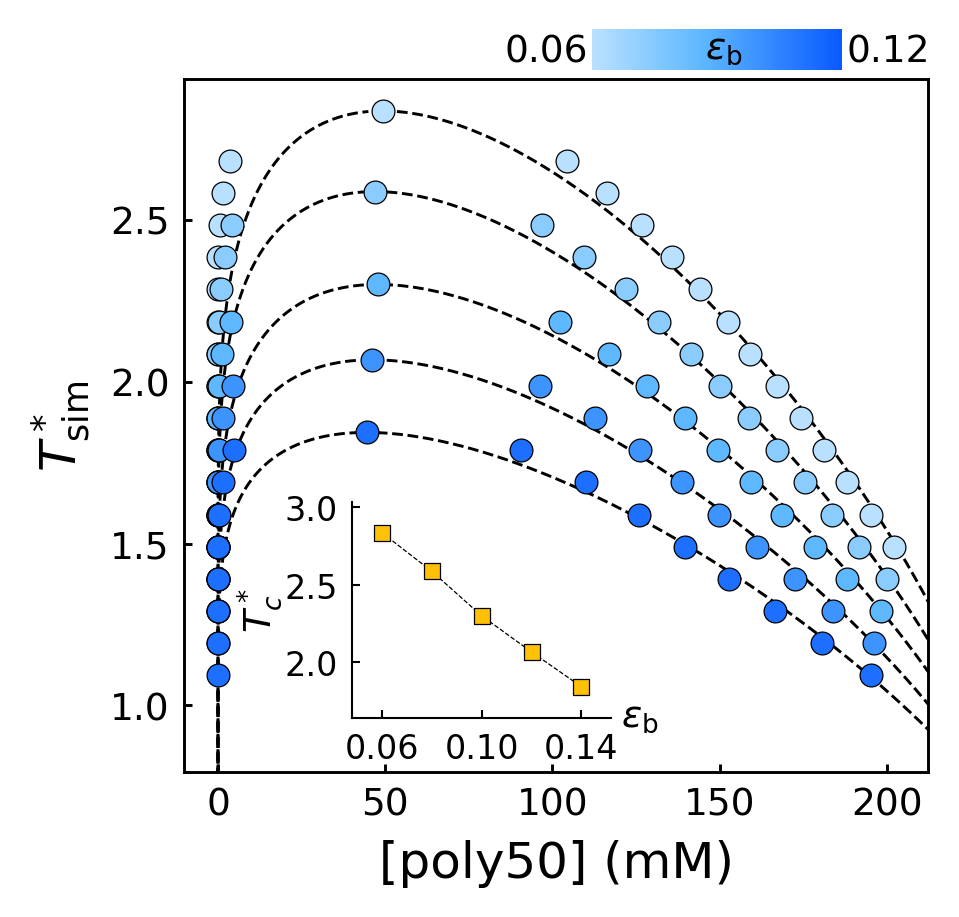

/tmp/ipykernel_1723015/2566504744.py:152: RuntimeWarning: divide by zero encountered in divide
  chis = delta_eps / T + chi0
/tmp/ipykernel_1723015/2566504744.py:106: RuntimeWarning: invalid value encountered in double_scalars
  b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
/tmp/ipykernel_1723015/2566504744.py:117: RuntimeWarning: invalid value encountered in double_scalars
  j11 = g1**2 * (- d1lnb * b * (1 - c) / (1 - b)**2 + n * (d1lna - d1lnb) * c * b / (1 - b)) - 1
/tmp/ipykernel_1723015/2566504744.py:119: RuntimeWarning: invalid value encountered in double_scalars
  j12 = (j11 + 1) * c + g1 * n * c * (d1lna - d1lnb)
/tmp/ipykernel_1723015/2566504744.py:107: RuntimeWarning: invalid value encountered in double_scalars
  c = np.power(a / b, n)
/tmp/ipykernel_1723015/2566504744.py:109: RuntimeWarning: invalid value encountered in double_scalars
  g1 = (1. - b) / (1. - np.power(a / b, n) * b)
/tmp/ipykernel_1723015/2566504744.py:110: RuntimeWarning: invalid

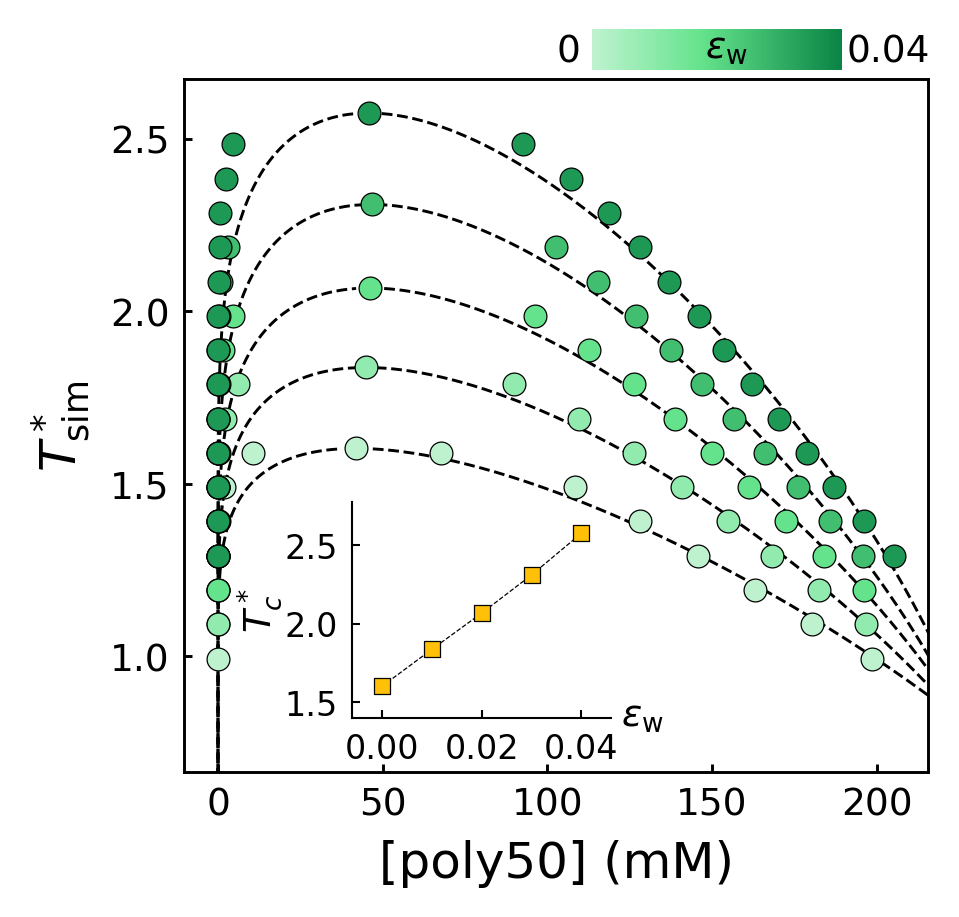

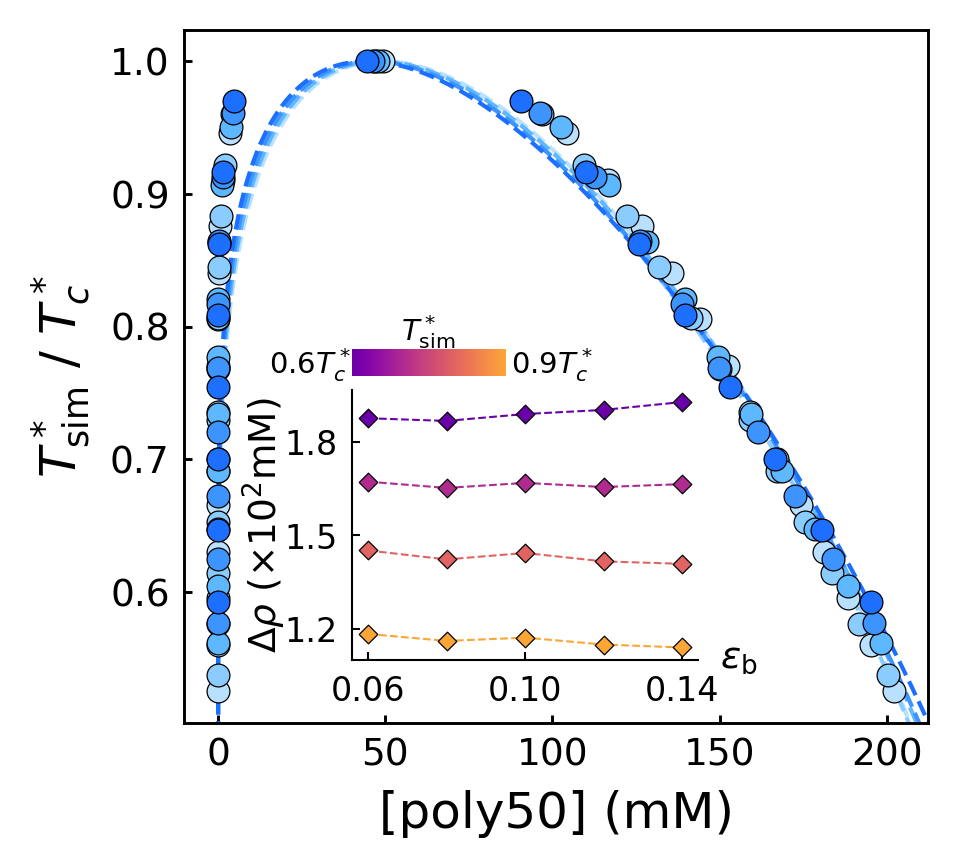

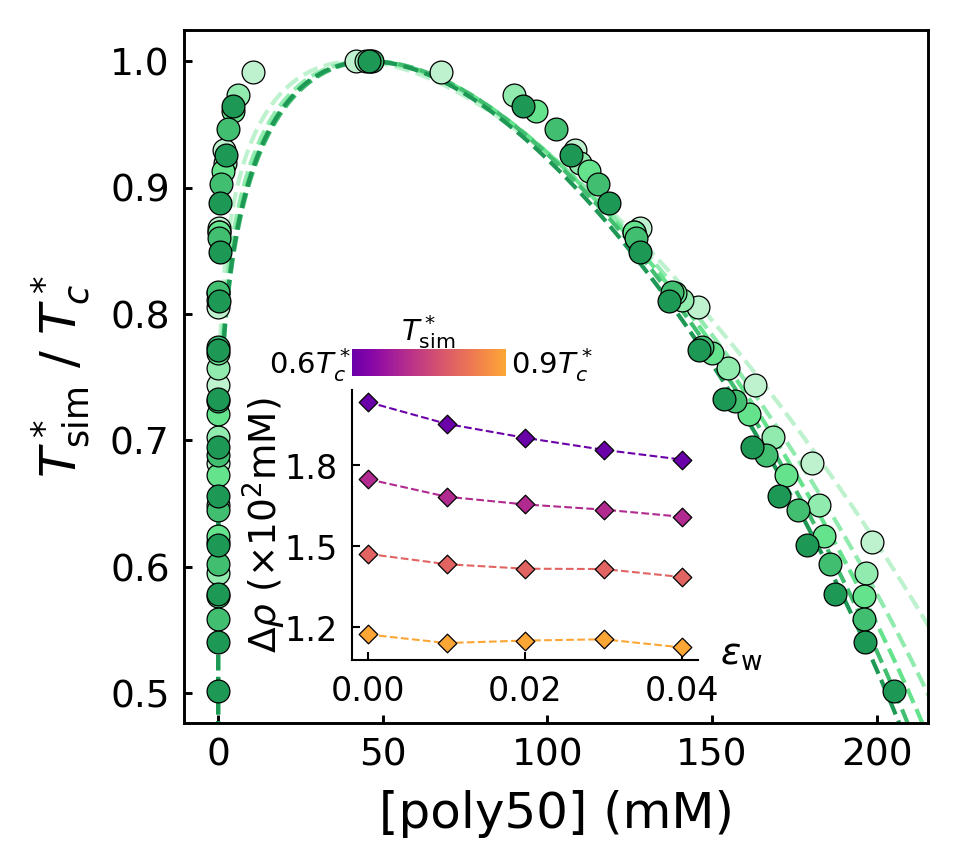

In [5]:
# Fig.D/E/H/I
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.optimize import leastsq

## Plot coexistence curve
def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

def calculate_phase_diagram(fixed_part):

    protein = 'poly50'
    density_data = {} # concentration of high/low density phase
    if fixed_part == 'e_b':
        fix_value = '0.12'
        param_idx, label_idx = 2, 3
    if fixed_part == 'e_w':
        fix_value = '0.02'
        param_idx, label_idx = 3, 2

    ## Plot density profile
    folders = os.listdir(f'traj/{protein}')
    for folder in folders:
        param = folder.split('_')
        if len(param) == 1: # removing HPS model or not
            continue
        if len(param) != 1 and param[param_idx] != fix_value:
            continue
        data_folder = f'data/{protein}/{folder}'
        RHO_H, RHO_L, T = [], [], []
        for temp in range(0, 1000, 1):
            traj_folder = f'traj/{protein}/{folder}/{temp}'
            if not os.path.exists(traj_folder):
                continue
            u = mda.Universe(f'{traj_folder}/{temp}.gsd', f'{traj_folder}/{temp}.dcd', pbc=True)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            mass = u.atoms.masses
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]
            zmax, zmin = lenz / 2, - lenz / 2
            nbins = 500
            dz = lenz / nbins

            if os.path.exists(f'{data_folder}/{temp}_dp.npy'):
                rhoave = np.load(f'{data_folder}/{temp}_dp.npy')
            else:
                count = 0
                rhosum = np.zeros(nbins)
                for frame in np.arange(300, nlen, 2):
                    if frame % 100 == 0:
                        print(frame)
                    ts = u.trajectory[frame]
                    cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                    massz = np.zeros(nbins)
                    for i in range(natoms):
                        nposz = ts.positions[i][2] - cmassz
                        nmass = mass[i]
                        idx = int((nposz - zmin) / dz)
                        if idx >= 500:
                            idx -= 500
                        if idx < 0:
                            idx += 500
                        massz[idx] += nmass
                    rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                    rhosum += rhoz
                    count += 1
                rhoave = rhosum / count
                rhoidx = np.where(rhoave > max(rhoave) * 0.2)
                mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
                if mc_idx > 0:
                    tmp = rhoave[:mc_idx].copy()
                    rhoave[:-mc_idx] = rhoave[mc_idx:]
                    rhoave[-mc_idx:] = tmp
                if mc_idx < 0:
                    tmp = rhoave[mc_idx:].copy()
                    rhoave[-mc_idx:] = rhoave[:mc_idx]
                    rhoave[:-mc_idx] = tmp
                
                if not os.path.exists(data_folder):
                    os.makedirs(data_folder)
                np.save(f'{data_folder}/{temp}_dp.npy', rhoave)
            
            rho_max = max(rhoave)
            rho_min = min(rhoave)
            rho_hd, rho_ld = 0, 0
            count_hd, count_ld = 0, 0
            for rho in rhoave:
                if rho >= rho_max * 0.95:
                    rho_hd += rho
                    count_hd += 1
                if rho <= rho_min + 50:
                    rho_ld += rho
                    count_ld += 1
            rho_hd /= count_hd
            rho_ld /= count_ld

            rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
            rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

            if abs(rho_hd - rho_ld) <= 50:
                continue

            T.append(temp)
            RHO_H.append(rho_hd)
            RHO_L.append(rho_ld)
        
        density_data[param[label_idx]] = [np.array(T), np.array(RHO_H), np.array(RHO_L)]

    tc_list = {}
    for parameter_set in density_data:
        T = density_data[parameter_set][0]
        RHO_H = density_data[parameter_set][1]
        RHO_L = density_data[parameter_set][2]
        
        delta_rho = RHO_H - RHO_L
        T_prods = T
        param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho), full_output=True)
        A, T_c = param[0]
        terr = np.sqrt(np.diag(param[1]))[1]

        tc_list[parameter_set] = T_c
    
    return density_data, tc_list

def plot_T(fixed_part):

    density_data, tc_list = calculate_phase_diagram(fixed_part)
    data_sorted = sorted(density_data.keys(), reverse=False)

    if fixed_part == 'e_b':
        label_tag = '\epsilon_{\mathregular{w}}'
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256
        )
    if fixed_part == 'e_w':
        label_tag = '\epsilon_{\mathregular{b}}'
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256
        )
    clist = cmap_full(np.linspace(0.15, 0.85, len(data_sorted)))

    fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)

    for idx, parameter_set in enumerate(data_sorted):
        T, RHO_H, RHO_L = [], [], []
        T_tmp = density_data[parameter_set][0]
        RHO_H_tmp = density_data[parameter_set][1]
        RHO_L_tmp = density_data[parameter_set][2]
        T_c = tc_list[parameter_set]
        for i in range(len(T_tmp)):
            if T_tmp[i] % 10 == 0:
                T.append(T_tmp[i])
                RHO_H.append(RHO_H_tmp[i])
                RHO_L.append(RHO_L_tmp[i])
        T = np.array(T)
        RHO_H = np.array(RHO_H)
        RHO_L = np.array(RHO_L)

        rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
        plt.scatter(RHO_H*density_scale, T*Tstar_scale, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(RHO_L*density_scale, T*Tstar_scale, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(rhoc*density_scale, T_c*Tstar_scale, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.plot(rho_fit*density_scale, T_fit*Tstar_scale, color='k', ls='--', lw=0.7)

    y_major_locator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(y_major_locator)
    T_min = np.min([np.min(v[0]) for v in density_data.values()])
    T_max = np.max([v for v in tc_list.values()])
    rho_max = np.max([np.max(v[1]) for v in density_data.values()])*density_scale
    rho_min = np.min([np.min(v[2]) for v in density_data.values()])*density_scale
    x_margin = 0.05 * (rho_max - rho_min)
    plt.ylim((T_min-30)*Tstar_scale, (T_max+10)*Tstar_scale)
    plt.xlim(rho_min-x_margin, rho_max+x_margin)
    plt.xlabel('[poly50] (mM)', fontsize=12)
    plt.ylabel(r'$T^*_\mathregular{sim}$', fontsize=12)
    plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(0.7)

    cbar_ax = fig.add_axes([0.55, 0.89, 0.26, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_full(np.linspace(0.15, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])

    if fixed_part == 'e_w':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{b}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.43, 1.025, '0.06', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.12', transform=ax.transAxes, fontsize=9, zorder=10)
    if fixed_part == 'e_b':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{w}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.50, 1.025, '0', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.04', transform=ax.transAxes, fontsize=9, zorder=10)

    ## Plot the inset figure of tc vs. eb/ew
    TC, PARAM = [], []
    for idx, parameter_set in enumerate(data_sorted):
        TC.append(tc_list[parameter_set]*Tstar_scale)
        PARAM.append(float(parameter_set))
    
    axin = fig.add_axes([0.3, 0.17, 0.27, 0.24])
    axin.set_facecolor("none")
    axin.scatter(PARAM, TC, marker='s', c='#FFC107', s=15, edgecolors='k', linewidths=0.3, zorder=10)
    axin.plot(PARAM, TC, '--k', lw=0.3)
    axin.tick_params(labelsize=8, direction='in', length=2, width=0.5)
    window = float(max(PARAM)) - float(min(PARAM))
    axin.set_xlim(float(min(PARAM)) - window*0.15, float(max(PARAM)) + window*0.15)
    axin.set_xticks(PARAM[::2])
    axin.set_ylim(min(TC)-0.2, max(TC)+0.2)
    axin.set_ylabel(r'$T_c^*$', fontsize=9, labelpad=0)
    axin.spines['top'].set_visible(False)
    axin.spines['left'].set_linewidth(0.5)
    axin.spines['right'].set_visible(False)
    axin.spines['bottom'].set_linewidth(0.5)
    axin.text(float(max(PARAM))+window*0.2, min(TC)-0.25, r'$%s$'%label_tag, fontsize=9)
    # axin.text(float(min(PARAM))-window*0.3, max(TC)+0.30, r'$T_c^*$', fontsize=9)
    
    plt.savefig(f"../../figures/phase-diagram/new_plot/binodal_{fixed_part}.svg", format="svg", bbox_inches='tight')
    plt.show()

def plot_Tscale(fixed_part):

    temp_list = {'0.06':[171, 200, 229, 257], '0.08':[156, 182, 209, 234],
                 '0.10':[139, 162, 185, 209], '0.12':[125, 146, 167, 188],
                 '0.14':[112, 130, 149, 167], '0.04':[156, 182, 208, 234],
                 '0.03':[140, 163, 186, 209], '0.02':[125, 146, 167, 188],
                 '0.01':[111, 130, 148, 167], '0.00':[ 97, 113, 129, 145]}

    density_data, tc_list = calculate_phase_diagram(fixed_part)
    data_sorted = sorted(density_data.keys(), reverse=False)

    if fixed_part == 'e_b':
        label_tag = '\epsilon_{\mathregular{w}}'
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256
        )
    if fixed_part == 'e_w':
        label_tag = '\epsilon_{\mathregular{b}}'
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256
        )
    clist = cmap_full(np.linspace(0.15, 0.85, len(data_sorted)))

    fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)

    TC, PARAM = [], []
    for idx, parameter_set in enumerate(data_sorted):
        T_c = tc_list[parameter_set]
        TC.append(T_c)
        PARAM.append(float(parameter_set))
    
    for idx, parameter_set in enumerate(data_sorted):
        T, RHO_H, RHO_L = [], [], []
        T_tmp = density_data[parameter_set][0]
        RHO_H_tmp = density_data[parameter_set][1]
        RHO_L_tmp = density_data[parameter_set][2]
        T_c = tc_list[parameter_set]
        for i in range(len(T_tmp)):
            if T_tmp[i] % 10 == 0:
                T.append(T_tmp[i])
                RHO_H.append(RHO_H_tmp[i])
                RHO_L.append(RHO_L_tmp[i])
        T = np.array(T)
        RHO_H = np.array(RHO_H)
        RHO_L = np.array(RHO_L)

        rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
        plt.scatter(RHO_H*density_scale, T/T_c, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(RHO_L*density_scale, T/T_c, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(rhoc*density_scale, T_c/T_c, s=30, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.plot(rho_fit*density_scale, T_fit/T_c, color=clist[idx], ls='--', lw=1)

    rho_max = np.max([np.max(v[1]) for v in density_data.values()])*density_scale
    rho_min = np.min([np.min(v[2]) for v in density_data.values()])*density_scale
    T_min = np.min([np.min(density_data[k][0])/tc_list[k] for k in density_data.keys()])
    T_max = 1
    x_margin = 0.05 * (rho_max - rho_min)
    y_margin = 0.05 * (T_max - T_min)
    plt.ylim(T_min-y_margin, T_max+y_margin)
    plt.xlim(rho_min-x_margin, rho_max+x_margin)
    plt.xlabel('[poly50] (mM)', fontsize=12)
    plt.ylabel(r'$T^*_\mathregular{sim}\ /\ T^*_c$', fontsize=12)
    plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(0.7)

    axin = fig.add_axes([0.3, 0.18, 0.36, 0.3])
    axin.set_zorder(10)

    T_set = [0.6, 0.7, 0.8, 0.9]
    
    DELTA_RHO = []
    for idx, parameter_set in enumerate(data_sorted):
        T, RHO_H, RHO_L = [], [], []
        T_tmp = density_data[parameter_set][0]
        RHO_H_tmp = density_data[parameter_set][1]
        RHO_L_tmp = density_data[parameter_set][2]
        
        for temp in temp_list[parameter_set]:
            RHO_H.append(RHO_H_tmp[list(T_tmp).index(temp)])
            RHO_L.append(RHO_L_tmp[list(T_tmp).index(temp)])
        
        DELTA_RHO.append(np.array(RHO_H) - np.array(RHO_L))
    
    width = max(list(map(float, data_sorted)))-min(list(map(float, data_sorted)))

    DELTA_RHO_array = np.array(DELTA_RHO)
    clist = cm.plasma(np.linspace(0.2, 0.8, len(T_set)))
    for i in range(len(T_set)):
        delta_rho = DELTA_RHO_array[:, i]*density_scale
        axin.scatter(list(map(float, data_sorted)), delta_rho/100, marker='D', color=clist[i], s=10, edgecolors='k', linewidths=0.3, zorder=10)
        axin.plot(list(map(float, data_sorted)), delta_rho/100, ls='--', color=clist[i], lw=0.5, zorder=1)
        # axin.text(list(map(float, data_sorted))[0]+width*0.03, (delta_rho[0]+3)/100, '%.1f $T_c^*$'%T_set[i], fontsize=8, color=clist[i])

    cbar_ax = fig.add_axes([0.3, 0.495, 0.16, 0.03])
    cbar_ax.set_zorder(2)
    cmap_partial = mpl.colors.ListedColormap(cm.plasma(np.linspace(0.2, 0.8, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])
    axin.text(0.14, 1.18, r'$T_\mathregular{sim}^*$', transform=axin.transAxes, fontsize=7, zorder=10)
    axin.text(-0.24, 1.06, r'0.6$T_c^*$', transform=axin.transAxes, fontsize=7, zorder=10)
    axin.text(0.46, 1.06, r'0.9$T_c^*$', transform=axin.transAxes, fontsize=7, zorder=10)
    
    axin.set_facecolor("none")
    y_major_locator = MultipleLocator(0.3)
    axin.yaxis.set_major_locator(y_major_locator)
    axin.text(max(list(map(float, data_sorted)))+width*0.12, (np.min(DELTA_RHO_array)-35)/100*density_scale,\
            r'$%s$'%label_tag, fontsize=9)
    axin.set_ylabel(r'$\Delta\rho$ ($\times 10^2$mM)', fontsize=9, labelpad=-1)
    axin.tick_params(labelsize=8, direction='in', length=2, width=0.5)
    axin.set_xticks(PARAM[::2])
    axin.spines['top'].set_visible(False)
    axin.spines['left'].set_linewidth(0.5)
    axin.spines['right'].set_visible(False)
    axin.spines['bottom'].set_linewidth(0.5)

    plt.savefig(f"../../figures/phase-diagram/new_plot/binodal_{fixed_part}_scale.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_T('e_w')
plot_T('e_b')
plot_Tscale('e_w')
plot_Tscale('e_b')

/home/swalker/.conda/envs/calvados/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/swalker/.conda/envs/calvados/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


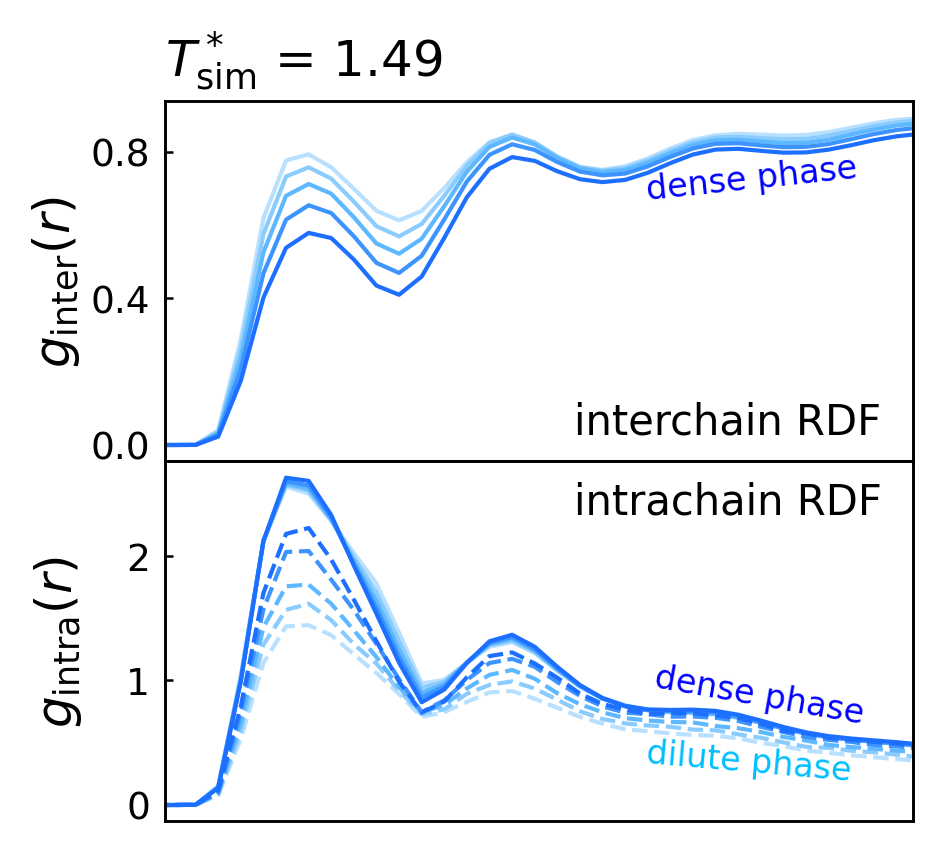

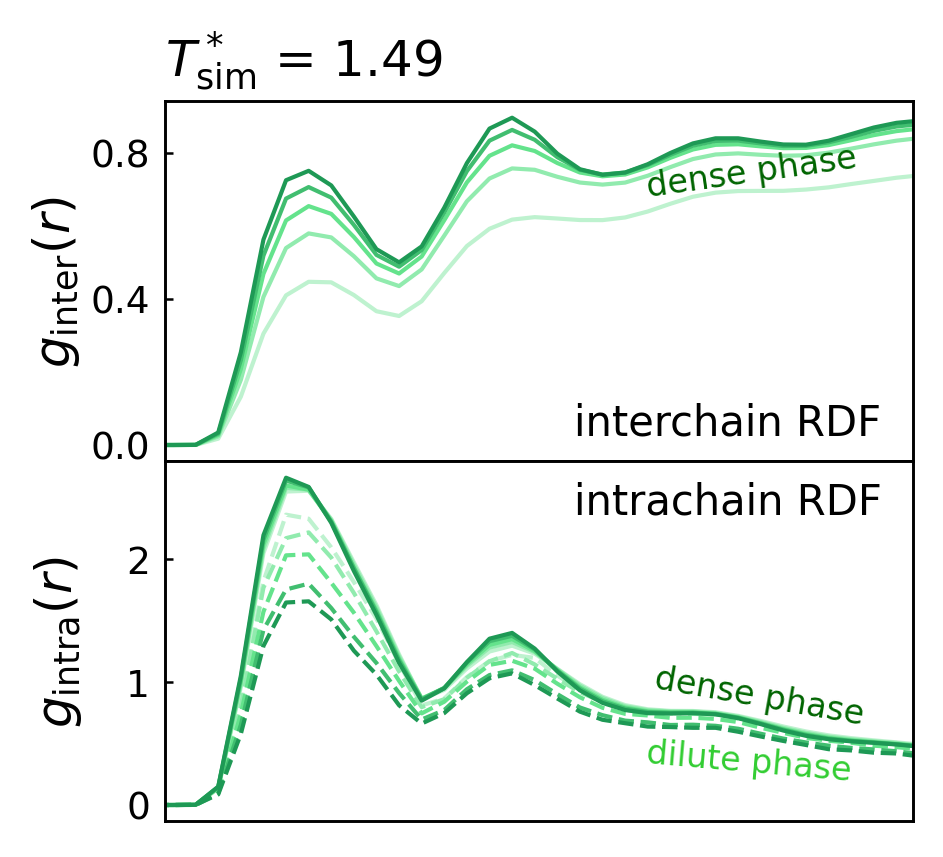

In [6]:
# Fig.F/J

import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from MDAnalysis.analysis import rdf
from scipy.optimize import curve_fit
from MDAnalysis.transformations import unwrap
from MDAnalysis.lib.mdamath import make_whole
from matplotlib.colors import LinearSegmentedColormap, Normalize

def lj(r,epsilon,sigma):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, e_h, e_b, e_w):
	lj_potential = 4 * e_h * ((sigma / r)**12 - (sigma / r)**6)
	lj_potential_diff = 24 * e_h / r * (2 * (sigma / r)**12 - (sigma / r)**6)
	if r <= 2**(1.0 / 6.0) * sigma:
		V = lj_potential + (1 - lam) * e_h\
          + e_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * np.exp(-(r-r_w)**2 / var_w)
		F = lj_potential_diff\
          + e_b * 2 * (r-r_b) / var_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * 2 * (r-r_w) / var_w * np.exp(-(r-r_w)**2 / var_w)
	else:
		V = lam * lj_potential\
          + e_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * np.exp(-(r-r_w)**2 / var_w)
		F = lam * lj_potential_diff\
          + e_b * 2 * (r-r_b) / var_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * 2 * (r-r_w) / var_w * np.exp(-(r-r_w)**2 / var_w)
	return V

def density_function(z, rho1, rho2, z0, deltaz):
    return (rho1 + rho2)/2 + (rho2 - rho1)/2*np.tanh((z - z0)/deltaz)

def calculate_chain_volume(u, chain_length):
    u_copy = u.copy()
    n_chains = len(u_copy.atoms) // chain_length
    chain_atoms = [u_copy.atoms[i*chain_length:(i+1)*chain_length] for i in range(n_chains)]
    volumes = []
    for ts in u_copy.trajectory:
        for chain in chain_atoms:
            make_whole(chain)
            pos = chain.positions
            bbox_size = np.ptp(pos, axis=0)
            volume = np.prod(bbox_size)
            volumes.append(volume)
    return np.mean(volumes)

protein = 'poly50'

def plot_rdf(fixed_part):

    if fixed_part == 'e_b':
        fix_value = 0.12
        param_idx, label_idx = 2, 3
        param_tag, label_tag = 'e_b', '\epsilon_{\mathregular{w}}'
    if fixed_part == 'e_w':
        fix_value = 0.02
        param_idx, label_idx = 3, 2
        param_tag, label_tag = 'e_w', '\epsilon_{\mathregular{b}}'
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[3.2, 3], facecolor='w', dpi=300, sharex=True)
    plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.93, hspace=0)

    T_sim = 150
    if os.path.exists('data/'+protein+'/rdf_data_'+fixed_part+'.npz'):
        data = np.load('data/'+protein+'/rdf_data_'+fixed_part+'.npz')
        PARAM = data['param']
        XAXIS = data['xaxis']
        INTER_RDF = data['inter_rdf']
        INTRA_RDF = data['intra_rdf']
        INTRA_RDF_DILUTE = data['intra_rdf_dilute']
    else:
        folders = os.listdir('traj/' + protein)
        folders.sort()
        PARAM, XAXIS, INTER_RDF, INTRA_RDF, INTRA_RDF_DILUTE = [], [], [], [], []
        for folder in folders:
            param = folder.split('_')
            if len(param) == 1: # removing HPS model or not
                continue
            if param[param_idx] != str(fix_value):
                continue
            print(folder)
            des_param = float(param[label_idx])
            PARAM.append(des_param)

            gsd_file = os.path.join('traj', protein, folder, str(T_sim), '{}.gsd'.format(T_sim))
            dcd_file = os.path.join('traj', protein, folder, str(T_sim), '{}.dcd'.format(T_sim))
            dat_file = os.path.join('data', protein, folder, '{}_dp.npy'.format(T_sim))
            u = mda.Universe(gsd_file, dcd_file)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            chain_length = 50
            nchains = int(natoms / chain_length)
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]
            conc = np.load(dat_file)
            axisz = np.linspace(-lenz/2, lenz/2, len(conc))

            half_bins = int(len(axisz)/2)
            fit_x = -axisz[:half_bins]
            fit_y = (conc[:half_bins] + conc[half_bins:][::-1])/2
            bounds = ([0, 0, 0, 0], [max(conc), max(conc), max(axisz), max(axisz)])
            params, covariance = curve_fit(density_function, fit_x, fit_y, bounds=bounds)
            bound_z = params[2]

            vbox = lenx * leny * lenz
            vinter = lenx * leny * 2 * bound_z
            vintra = calculate_chain_volume(u, chain_length)

            # calculate interchain RDF
            print('Calculating interchain RDF ...')
            interRDF = []
            for i in range(nchains):
                ag1 = u.select_atoms('index %i:%i'%(i*chain_length, (i+1)*chain_length-1))
                ag2 = u.select_atoms('not index %i:%i'%(i*chain_length, (i+1)*chain_length-1))
                rdf = mda.analysis.rdf.InterRDF(ag1, ag2, range=[0, 1.6], nbins=50)
                rdf.run()
                rdf_result = rdf.rdf * vinter / vbox
                rdf_result[rdf.bins < 0.46] = 0
                interRDF.append(rdf_result)
            print('Interchain RDF calculation complete.')
                
            # calculate intrachain RDF
            print('Calculating intrachain RDF ...')
            intraRDF = []
            for i in range(nchains):
                ag1 = u.select_atoms('index %i:%i'%(i*chain_length, (i+1)*chain_length-1))
                ag2 = u.select_atoms('index %i:%i'%(i*chain_length, (i+1)*chain_length-1))
                rdf = mda.analysis.rdf.InterRDF(ag1, ag2, range=[0, 1.6], nbins=50)
                rdf.run()
                rdf_result = rdf.rdf * vintra / vbox
                rdf_result[rdf.bins < 0.46] = 0
                intraRDF.append(rdf_result)
            print('Intrachain RDF calculation complete.')

            # calculate dilute phase intrachain RDF
            print('Calculating dilute phase intrachain RDF ...')
            gsd_file = os.path.join('traj', protein, folder, '1chain/1chain.gsd')
            dcd_file = os.path.join('traj', protein, folder, '1chain/1chain.dcd')
            u = mda.Universe(gsd_file, dcd_file)
            chain_length = 50
            natoms = u.atoms.n_atoms
            nchains = int(natoms / chain_length)
            vdilute = calculate_chain_volume(u, chain_length)
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]
            vbox = lenx * leny * lenz
            intraRDF_dilute = []
            for i in range(nchains):
                ag = u.select_atoms('index %i:%i'%(i*chain_length, (i+1)*chain_length-1))
                rdf = mda.analysis.rdf.InterRDF(ag, ag, range=[0, 1.6], nbins=50)
                rdf.run()
                rdf_result = rdf.rdf * vdilute / vbox
                rdf_result[rdf.bins < 0.46] = 0
                intraRDF_dilute.append(rdf_result)
            print('Dilute phase intrachain RDF calculation complete.')

            ## Save the simulation result
            XAXIS.append(rdf.bins)
            INTER_RDF.append(np.mean(interRDF, axis=0))
            INTRA_RDF.append(np.mean(intraRDF, axis=0))
            INTRA_RDF_DILUTE.append(np.mean(intraRDF_dilute, axis=0))
        np.savez_compressed('data/'+protein+'/rdf_data_'+fixed_part+'.npz',
                            param=PARAM, xaxis=XAXIS, inter_rdf=INTER_RDF,
                            intra_rdf=INTRA_RDF, intra_rdf_dilute=INTRA_RDF_DILUTE)

    if fixed_part == 'e_b':
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256
        )
    if fixed_part == 'e_w':
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256
        )
    clist = cmap_full(np.linspace(0.15, 0.85, len(PARAM)))

    for i in range(len(PARAM)):
        ax1.plot(XAXIS[i]*10, INTER_RDF[i], label=r'%.2f'%(PARAM[i]), color=clist[i], lw=1)
        if i == 4:
            ax2.plot(XAXIS[i]*10, INTRA_RDF[i], color=clist[i], ls='-', lw=1, label='dense phase')
            ax2.plot(XAXIS[i]*10, INTRA_RDF_DILUTE[i], color=clist[i], ls='--', lw=1, label='dilute phase')
        else:
            ax2.plot(XAXIS[i]*10, INTRA_RDF[i], color=clist[i], ls='-', lw=1)
            ax2.plot(XAXIS[i]*10, INTRA_RDF_DILUTE[i], color=clist[i], ls='--', lw=1)

    # ax1.axvline(x=6, color='r', linestyle='--', linewidth=1.3)
    # ax2.axvline(x=6, color='r', linestyle='--', linewidth=1.3)
    # ax1.axvline(x=9, color='purple', linestyle='--', linewidth=1.3)
    # ax2.axvline(x=9, color='purple', linestyle='--', linewidth=1.3)
    ax1.text(10, 0.03, 'interchain RDF', fontsize=10)
    ax2.text(10, np.max(INTRA_RDF)*0.89, 'intrachain RDF', fontsize=10)

    if fixed_part == 'e_b':
        ax1.text(x=11, y=0.68, s='dense phase', rotation=8, color='darkgreen', fontsize=8)
        ax2.text(x=11, y=0.20, s='dilute phase', rotation=-5, color='limegreen', fontsize=8)
        ax2.text(x=11.1, y=0.66, s='dense phase', rotation=-10, color='darkgreen', fontsize=8)
    if fixed_part == 'e_w':
        ax1.text(x=11, y=0.67, s='dense phase', rotation=6, color='blue', fontsize=8)
        ax2.text(x=11, y=0.20, s='dilute phase', rotation=-5, color='deepskyblue', fontsize=8)
        ax2.text(x=11.1, y=0.66, s='dense phase', rotation=-10, color='blue', fontsize=8)

    ax1.text(0, 1.07, r'$T_\mathregular{sim}^*$ = 1.49', fontsize=12, transform=ax1.transAxes)

    ax1.set_xlim(4.2, 14.8)
    # ax2.set_xlabel(r'$r$ ($\mathregular{\AA}$)', fontsize=12)
    ax1.set_ylabel(r'$g_\mathregular{inter}(r)$', fontsize=12, labelpad=2)
    ax2.set_ylabel(r'$g_\mathregular{intra}(r)$', fontsize=12, labelpad=10)
    ax1.set_yticks([0, 0.4, 0.8])
    ax1.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax2.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax1.spines['top'].set_linewidth(0.7)
    ax2.spines['top'].set_linewidth(0.7)
    ax1.spines['left'].set_linewidth(0.7)
    ax2.spines['left'].set_linewidth(0.7)
    ax1.spines['right'].set_linewidth(0.7)
    ax2.spines['right'].set_linewidth(0.7)
    ax1.spines['bottom'].set_linewidth(0.7)
    ax2.spines['bottom'].set_linewidth(0.7)
    ax1.tick_params(axis='x', which='both', length=0)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xticks([])
    plt.savefig(f"../../figures/phase-diagram/new_plot/rdf_{fixed_part}.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_rdf('e_w')
plot_rdf('e_b')

/tmp/ipykernel_2295742/1399214330.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(0, 5.6, color="#BBBBBB", alpha=0.1, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/1399214330.py:162: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(5.6, 8.6, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/1399214330.py:163: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(8.6, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')


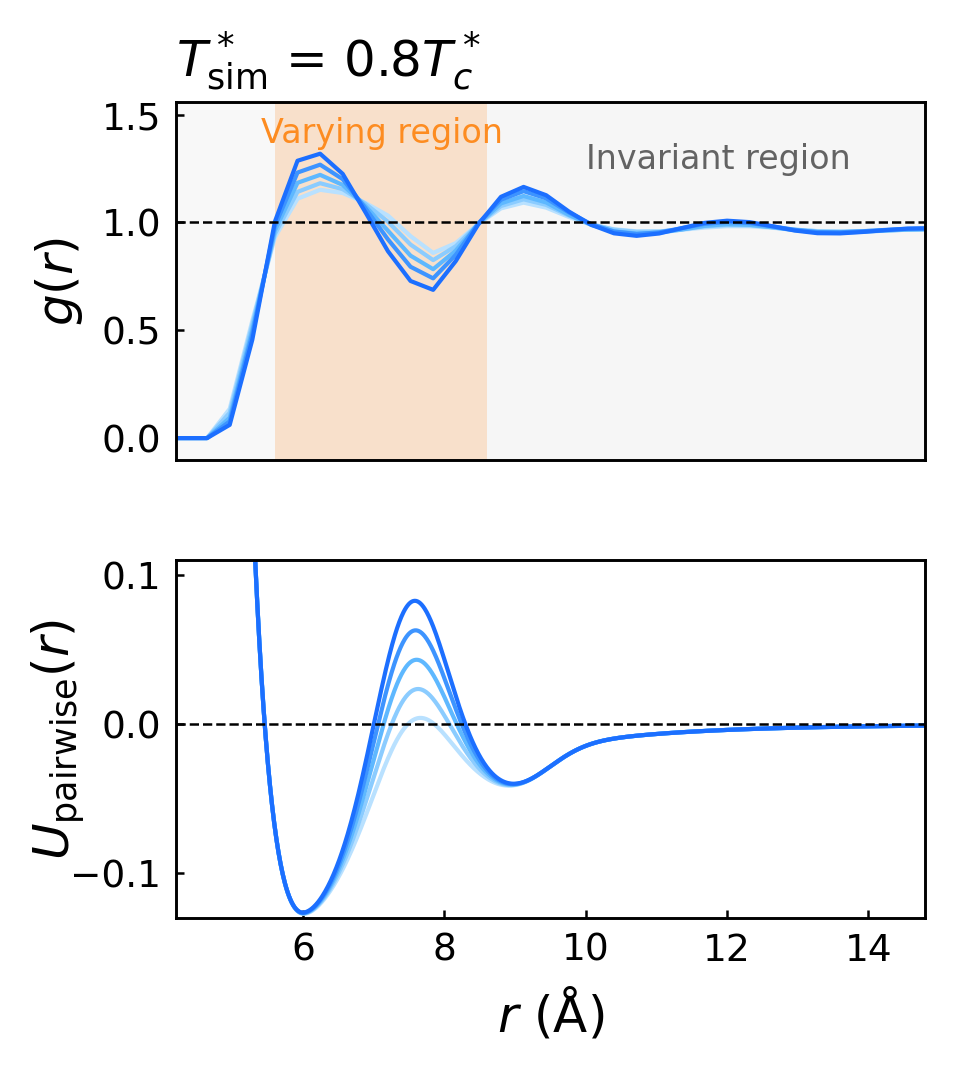

/tmp/ipykernel_2295742/1399214330.py:166: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(0, 5.6, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/1399214330.py:167: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(5.6, 7.1, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/1399214330.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.axvspan(7.1, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')


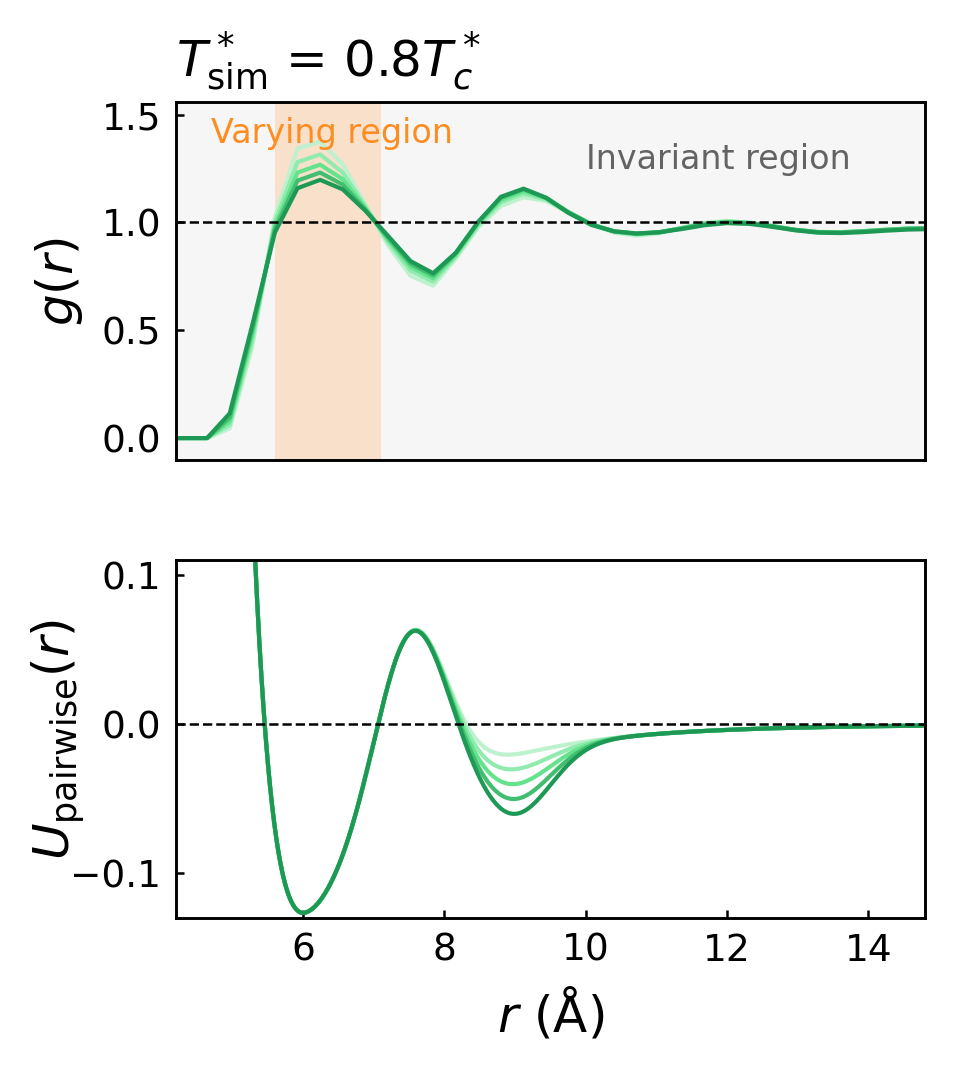

In [3]:
# Fig.J/K

import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from MDAnalysis.analysis import rdf
from matplotlib.colors import LinearSegmentedColormap, Normalize

def lj(r,epsilon,sigma):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, e_h, e_b, e_w):
	lj_potential = 4 * e_h * ((sigma / r)**12 - (sigma / r)**6)
	lj_potential_diff = 24 * e_h / r * (2 * (sigma / r)**12 - (sigma / r)**6)
	if r <= 2**(1.0 / 6.0) * sigma:
		V = lj_potential + (1 - lam) * e_h\
          + e_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * np.exp(-(r-r_w)**2 / var_w)
		F = lj_potential_diff\
          + e_b * 2 * (r-r_b) / var_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * 2 * (r-r_w) / var_w * np.exp(-(r-r_w)**2 / var_w)
	else:
		V = lam * lj_potential\
          + e_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * np.exp(-(r-r_w)**2 / var_w)
		F = lam * lj_potential_diff\
          + e_b * 2 * (r-r_b) / var_b * np.exp(-(r-r_b)**2 / var_b)\
          - e_w * 2 * (r-r_w) / var_w * np.exp(-(r-r_w)**2 / var_w)
	return V

def plot_rdf_scale(fixed_part):

    protein = 'poly50'

    temp_list = {'0.06':[171, 200, 229, 257], '0.08':[156, 182, 209, 234],
                '0.10':[139, 162, 185, 209], '0.12':[125, 146, 167, 188],
                '0.14':[112, 130, 149, 167], '0.04':[156, 182, 208, 234],
                '0.03':[140, 163, 186, 209], '0.02':[125, 146, 167, 188],
                '0.01':[111, 130, 148, 167], '0.00':[ 97, 113, 129, 145]}

    if fixed_part == 'e_b':
        fixed_value = '0.12'
        param_idx, label_idx = 2, 3
        param_tag, label_tag = 'e_b', '\epsilon_{\mathregular{w}}'
    if fixed_part == 'e_w':
        fixed_value = '0.02'
        param_idx, label_idx = 3, 2
        param_tag, label_tag = 'e_w', '\epsilon_{\mathregular{b}}'
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[3.2, 3.4], facecolor='w', dpi=300, sharex=True)
    plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.93, hspace=0.28)

    cal2j = 4.184

    if os.path.exists('traj/'+protein+'/data0/param_'+fixed_part+'_scale.npy'):
        PARAM = np.load('traj/'+protein+'/data0/param_'+fixed_part+'_scale.npy')
        XAXIS = np.load('traj/'+protein+'/data0/xaxis_'+fixed_part+'_scale.npy')
        RDF = np.load('traj/'+protein+'/data0/rdf_'+fixed_part+'_scale.npy')
    else:
        folders = os.listdir('traj/' + protein)
        folders.sort()
        PARAM, XAXIS, RDF, PMF = [], [], [], []
        for folder in folders:
            param = folder.split('_')
            if len(param) == 1: # removing HPS model or not
                continue
            if param[param_idx] != fixed_value:
                continue
            if param[1] != '0.20':
                continue
            print(folder)
            des_param = float(param[label_idx])
            PARAM.append(des_param)
            T_sim = temp_list[param[label_idx]][2] # 0.8*Tc
            print(T_sim)

            traj_folder = 'traj/' + protein + '/' + folder + '/' + str(T_sim) + '/'
            data_folder = 'data/' + protein + '/' + folder + '/'
            u = mda.Universe(traj_folder+'%i.gsd'%T_sim, traj_folder+'%i.dcd'%T_sim)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / 50)
            mass = u.atoms.masses
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]

            rhoave = np.load(data_folder + '%i_dp.npy'%T_sim)
            rho_max = max(rhoave)
            rho_min = min(rhoave)
            rho_hd, rho_ld = 0, 0
            count_hd, count_ld = 0, 0
            for rho in rhoave:
                if rho >= rho_max * 0.95:
                    rho_hd += rho
                    count_hd += 1
                if rho <= rho_min + 50:
                    rho_ld += rho
                    count_ld += 1
            rho_hd /= count_hd
            rho_ld /= count_ld

            rho0 = sum(mass) / (lenx * leny * lenz * 6.02214e-1)

            ag = u.select_atoms('all')
            rdf = mda.analysis.rdf.InterRDF(ag, ag, range=[0, 1.6], nbins=50, exclude_same=None)
            rdf.run()

            g_r = rdf.rdf
            r = rdf.bins
            g_r[r < 0.48] = 0

            ## Save the simulation result
            XAXIS.append(r)
            RDF.append(g_r)
            # PMF.append(-8.314e-3*T_sim*np.log(rdf.rdf)/cal2j)
        np.save('traj/'+protein+'/data0/param_'+fixed_part+'_scale.npy', np.array(PARAM))
        np.save('traj/'+protein+'/data0/xaxis_'+fixed_part+'_scale.npy', np.array(XAXIS))
        np.save('traj/'+protein+'/data0/rdf_'+fixed_part+'_scale.npy', np.array(RDF))

    if fixed_part == 'e_b':
        Elist = [0.00, 0.01, 0.02, 0.03, 0.04]
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256
        )
    if fixed_part == 'e_w':
        Elist = [0.06, 0.08, 0.10, 0.12, 0.14]
        cmap_full = LinearSegmentedColormap.from_list(
            "bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256
        )
    clist = cmap_full(np.linspace(0.15, 0.85, len(PARAM)))

    for i in range(len(PARAM)):
        ax1.plot(XAXIS[i]*10, RDF[i], label=r'%.2f'%(PARAM[i]), color=clist[i], lw=1)

    # Plot the potential function
    lam = 0.640
    sigma = 0.536
    r_m = 2**(1. / 6.) * sigma
    r_b = r_m + 0.15
    r_w = r_m + 0.30
    var_b, var_w = 0.005, 0.005
    R = np.arange(0.5, 2, 0.001)
    for i in range(len(Elist)):
        V = []
        if fixed_part == 'e_b':
            for r in R:
                V.append(hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, 0.20, 0.12, Elist[i]))
        if fixed_part == 'e_w':
            for r in R:
                V.append(hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, 0.20, Elist[i], 0.02))
        ax2.plot(R*10, V, color=clist[i], ls='-', lw=1)

    # ax1.axvline(x=0.6, color='r', linestyle='--', linewidth=1.3)
    # ax2.axvline(x=0.6, color='r', linestyle='--', linewidth=1.3)
    # ax1.axvline(x=0.9, color='purple', linestyle='--', linewidth=1.3)
    # ax2.axvline(x=0.9, color='purple', linestyle='--', linewidth=1.3)
    ax1.axhline(y=1, color='k', linestyle='--', linewidth=0.6)
    ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.6)

    if fixed_part == 'e_w':
        ax1.axvspan(0, 5.6, color="#BBBBBB", alpha=0.1, linewidth=0, edgecolor='none')
        ax1.axvspan(5.6, 8.6, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
        ax1.axvspan(8.6, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax1.text(5.4, 1.37, 'Varying region', fontsize=8, color="#FD8C21")
    if fixed_part == 'e_b':
        ax1.axvspan(0, 5.6, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax1.axvspan(5.6, 7.1, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
        ax1.axvspan(7.1, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax1.text(4.7, 1.37, 'Varying region', fontsize=8, color="#FD8C21")
    ax1.text(10, 1.25, 'Invariant region', fontsize=8, color="#636363")
    ax1.text(0, 1.07, r'$T_\mathregular{sim}^*$ = 0.8$T_c^*$', fontsize=12, transform=ax1.transAxes)

    ax1.set_xlim(4.2, 14.8)
    ax1.set_ylim(-0.1, 1.56)
    ax2.set_ylim(-0.13, 0.11)
    ax2.set_xlabel(r'$r$ ($\mathregular{\AA}$)', fontsize=12)
    ax1.set_ylabel(r'$g(r)$', fontsize=12, labelpad=4)
    ax2.set_ylabel(r'$U_\mathregular{pairwise}(r)$', fontsize=12, labelpad=-4)
    ax1.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax2.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax1.spines['top'].set_linewidth(0.7)
    ax2.spines['top'].set_linewidth(0.7)
    ax1.spines['left'].set_linewidth(0.7)
    ax2.spines['left'].set_linewidth(0.7)
    ax1.spines['right'].set_linewidth(0.7)
    ax2.spines['right'].set_linewidth(0.7)
    ax1.spines['bottom'].set_linewidth(0.7)
    ax2.spines['bottom'].set_linewidth(0.7)
    ax1.tick_params(axis='x', which='both', length=0)
    plt.savefig(f"../../figures/phase-diagram/new_plot/rdf_scale_{fixed_part}.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_rdf_scale('e_w')
plot_rdf_scale('e_b')

/tmp/ipykernel_2295742/127510544.py:145: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(0, 5.6, color='#BBBBBB', alpha=0.1, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/127510544.py:146: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(5.6, 8.6, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/127510544.py:147: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(8.6, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')


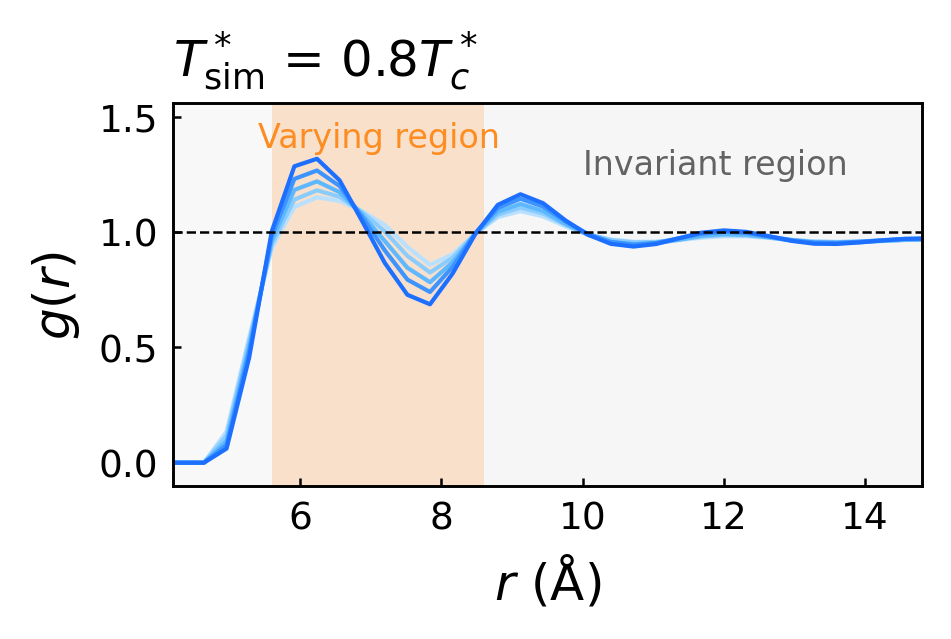

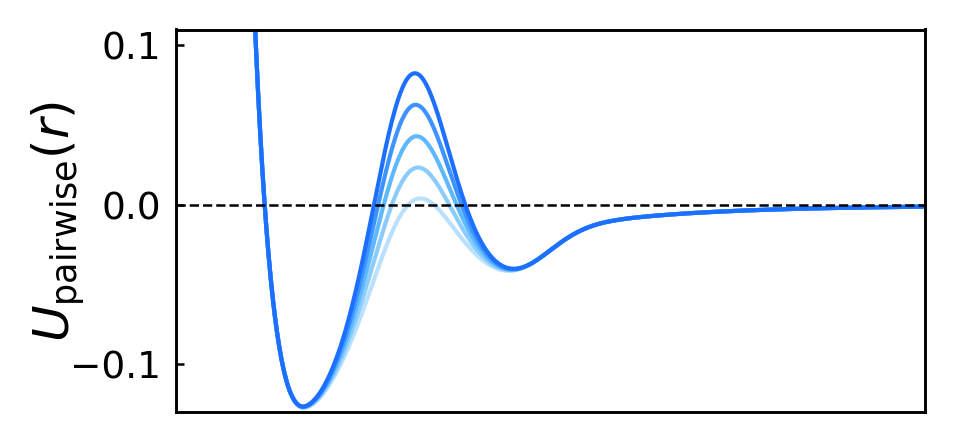

/tmp/ipykernel_2295742/127510544.py:150: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(0, 5.6, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/127510544.py:151: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(5.6, 7.1, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
/tmp/ipykernel_2295742/127510544.py:152: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_rdf.axvspan(7.1, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')


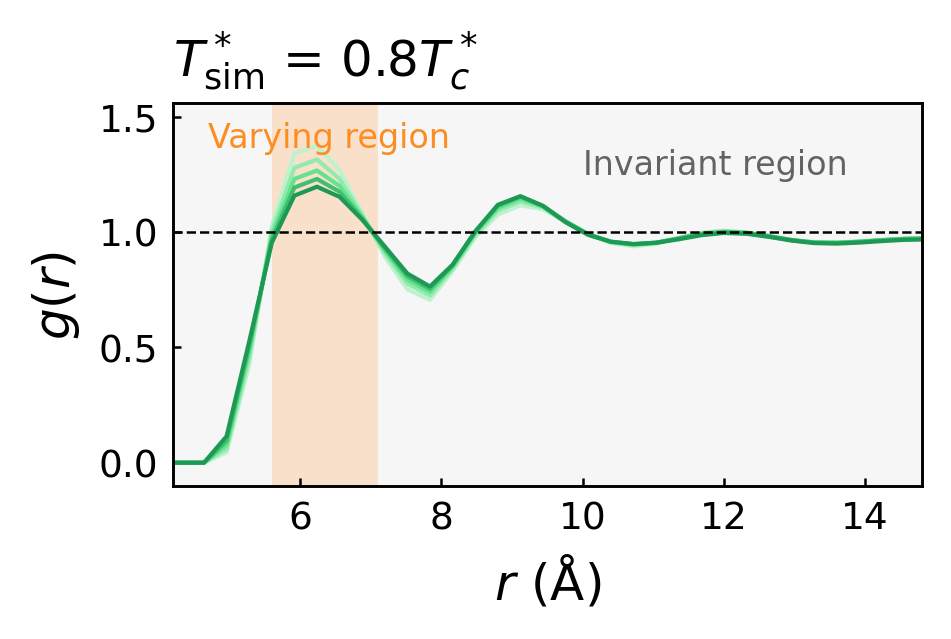

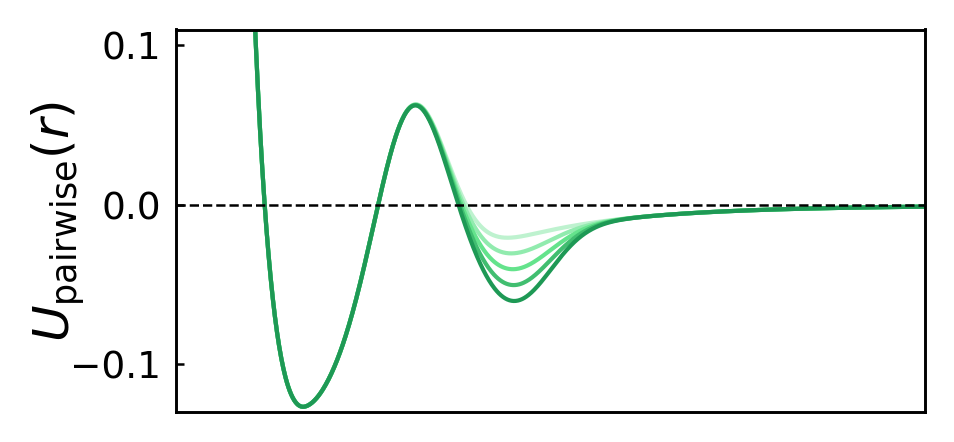

In [7]:
# Corrected copy of Cell 8 with proper \mathregular{} usage for the x-axis label
from matplotlib.colors import LinearSegmentedColormap, Normalize


def plot_rdf_scale(fixed_part):

    protein = 'poly50'

    temp_list = {
        '0.06': [171, 200, 229, 257],
        '0.08': [156, 182, 209, 234],
        '0.10': [139, 162, 185, 209],
        '0.12': [125, 146, 167, 188],
        '0.14': [112, 130, 149, 167],
        '0.04': [156, 182, 208, 234],
        '0.03': [140, 163, 186, 209],
        '0.02': [125, 146, 167, 188],
        '0.01': [111, 130, 148, 167],
        '0.00': [97, 113, 129, 145],
    }

    if fixed_part == 'e_b':
        fixed_value = '0.12'
        param_idx, label_idx = 2, 3
        param_tag, label_tag = 'e_b', '\epsilon_{\mathregular{w}}'
    if fixed_part == 'e_w':
        fixed_value = '0.02'
        param_idx, label_idx = 3, 2
        param_tag, label_tag = 'e_w', '\epsilon_{\mathregular{b}}'

    subplot_size = (3.2, 3.4 / 2)
    fig_rdf, ax_rdf = plt.subplots(1, 1, figsize=subplot_size, facecolor='w', dpi=300)
    fig_rdf.subplots_adjust(top=0.95, bottom=0.2, left=0.15, right=0.93)
    fig_pot, ax_pot = plt.subplots(1, 1, figsize=subplot_size, facecolor='w', dpi=300)
    fig_pot.subplots_adjust(top=0.95, bottom=0.2, left=0.15, right=0.93)

    cal2j = 4.184

    if os.path.exists('traj/' + protein + '/data0/param_' + fixed_part + '_scale.npy'):
        PARAM = np.load('traj/' + protein + '/data0/param_' + fixed_part + '_scale.npy')
        XAXIS = np.load('traj/' + protein + '/data0/xaxis_' + fixed_part + '_scale.npy')
        RDF = np.load('traj/' + protein + '/data0/rdf_' + fixed_part + '_scale.npy')
    else:
        folders = os.listdir('traj/' + protein)
        folders.sort()
        PARAM, XAXIS, RDF, PMF = [], [], [], []
        for folder in folders:
            param = folder.split('_')
            if len(param) == 1:  # removing HPS model or not
                continue
            if param[param_idx] != fixed_value:
                continue
            if param[1] != '0.20':
                continue
            print(folder)
            des_param = float(param[label_idx])
            PARAM.append(des_param)
            T_sim = temp_list[param[label_idx]][2]  # 0.8*Tc
            print(T_sim)

            traj_folder = 'traj/' + protein + '/' + folder + '/' + str(T_sim) + '/'
            data_folder = 'data/' + protein + '/' + folder + '/'
            u = mda.Universe(traj_folder + '%i.gsd' % T_sim, traj_folder + '%i.dcd' % T_sim)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / 50)
            mass = u.atoms.masses
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]

            rhoave = np.load(data_folder + '%i_dp.npy' % T_sim)
            rho_max = max(rhoave)
            rho_min = min(rhoave)
            rho_hd, rho_ld = 0, 0
            count_hd, count_ld = 0, 0
            for rho in rhoave:
                if rho >= rho_max * 0.95:
                    rho_hd += rho
                    count_hd += 1
                if rho <= rho_min + 50:
                    rho_ld += rho
                    count_ld += 1
            rho_hd /= count_hd
            rho_ld /= count_ld

            rho0 = sum(mass) / (lenx * leny * lenz * 6.02214e-1)

            ag = u.select_atoms('all')
            rdf = mda.analysis.rdf.InterRDF(ag, ag, range=[0, 1.6], nbins=50, exclude_same=None)
            rdf.run()

            g_r = rdf.rdf
            r = rdf.bins
            g_r[r < 0.48] = 0

            # Save the simulation result
            XAXIS.append(r)
            RDF.append(g_r)
            # PMF.append(-8.314e-3*T_sim*np.log(rdf.rdf)/cal2j)
        np.save('traj/' + protein + '/data0/param_' + fixed_part + '_scale.npy', np.array(PARAM))
        np.save('traj/' + protein + '/data0/xaxis_' + fixed_part + '_scale.npy', np.array(XAXIS))
        np.save('traj/' + protein + '/data0/rdf_' + fixed_part + '_scale.npy', np.array(RDF))

    if fixed_part == 'e_b':
        Elist = [0.00, 0.01, 0.02, 0.03, 0.04]
        cmap_full = LinearSegmentedColormap.from_list(
            'bright_green', ['#E4F9EC', '#64E38C', '#007A3D'], N=256
        )
    if fixed_part == 'e_w':
        Elist = [0.06, 0.08, 0.10, 0.12, 0.14]
        cmap_full = LinearSegmentedColormap.from_list(
            'bright_blue', ['#E0F2FF', '#5EB8FF', '#0050FF'], N=256
        )
    clist = cmap_full(np.linspace(0.15, 0.85, len(PARAM)))

    for i in range(len(PARAM)):
        ax_rdf.plot(XAXIS[i] * 10, RDF[i], label=r'%.2f' % (PARAM[i]), color=clist[i], lw=1)

    # Plot the potential function
    lam = 0.640
    sigma = 0.536
    r_m = 2 ** (1.0 / 6.0) * sigma
    r_b = r_m + 0.15
    r_w = r_m + 0.30
    var_b, var_w = 0.005, 0.005
    R = np.arange(0.5, 2, 0.001)
    for i in range(len(Elist)):
        V = []
        if fixed_part == 'e_b':
            for r in R:
                V.append(
                    hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, 0.20, 0.12, Elist[i])
                )
        if fixed_part == 'e_w':
            for r in R:
                V.append(
                    hps_desolvation(r, r_b, r_w, var_b, var_w, lam, sigma, 0.20, Elist[i], 0.02)
                )
        ax_pot.plot(R * 10, V, color=clist[i], ls='-', lw=1)

    ax_rdf.axhline(y=1, color='k', linestyle='--', linewidth=0.6)
    ax_pot.axhline(y=0, color='k', linestyle='--', linewidth=0.6)

    if fixed_part == 'e_w':
        ax_rdf.axvspan(0, 5.6, color='#BBBBBB', alpha=0.1, linewidth=0, edgecolor='none')
        ax_rdf.axvspan(5.6, 8.6, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
        ax_rdf.axvspan(8.6, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax_rdf.text(5.4, 1.37, 'Varying region', fontsize=8, color='#FD8C21')
    if fixed_part == 'e_b':
        ax_rdf.axvspan(0, 5.6, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax_rdf.axvspan(5.6, 7.1, color='#E89B53', alpha=0.3, linewidth=0, edgecolor='none')
        ax_rdf.axvspan(7.1, 20, color='#B0B0B0', alpha=0.1, linewidth=0, edgecolor='none')
        ax_rdf.text(4.7, 1.37, 'Varying region', fontsize=8, color='#FD8C21')
    ax_rdf.text(10, 1.25, 'Invariant region', fontsize=8, color='#636363')
    ax_rdf.text(0, 1.07, r'$T_\mathregular{sim}^*$ = 0.8$T_c^*$', fontsize=12, transform=ax_rdf.transAxes)

    ax_rdf.set_xlim(4.2, 14.8)
    ax_rdf.set_ylim(-0.1, 1.56)
    ax_pot.set_xlim(4.2, 14.8)
    ax_pot.set_ylim(-0.13, 0.11)
    ax_rdf.set_xlabel('$r$ ($\mathregular{\AA}$)', fontsize=12)
    ax_rdf.set_ylabel(r'$g(r)$', fontsize=12, labelpad=4)
    ax_pot.set_ylabel(r'$U_\mathregular{pairwise}(r)$', fontsize=12, labelpad=-4)
    ax_rdf.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax_pot.tick_params(labelsize=9, direction='in', length=2, width=0.6)
    ax_pot.set_xticks([])
    ax_pot.set_yticks([-0.1, 0, 0.1])
    ax_rdf.spines['top'].set_linewidth(0.7)
    ax_pot.spines['top'].set_linewidth(0.7)
    ax_rdf.spines['left'].set_linewidth(0.7)
    ax_pot.spines['left'].set_linewidth(0.7)
    ax_rdf.spines['right'].set_linewidth(0.7)
    ax_pot.spines['right'].set_linewidth(0.7)
    ax_rdf.spines['bottom'].set_linewidth(0.7)
    ax_pot.spines['bottom'].set_linewidth(0.7)
    ax_pot.tick_params(axis='x', which='both', length=0)

    fig_rdf.savefig(
        f"../../figures/phase-diagram/new_plot/rdf_scale_{fixed_part}.svg",
        format='svg',
        bbox_inches='tight',
    )
    fig_pot.savefig(
        f"../../figures/phase-diagram/new_plot/rdf_scale_{fixed_part}_potential.svg",
        format='svg',
        bbox_inches='tight',
    )
    plt.show()


plot_rdf_scale('e_w')
plot_rdf_scale('e_b')